In [1]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm

from GaLa import llaplace
from NN import DNN

# import os
# import re

# os.chdir("/home/s2113174/Projects-1")

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Tiaming Second Experiment


$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  k(x,\theta) = 
\begin{cases}
  0 &\text{if } x\in \left[0,\frac{1}{4} \right) \\
  \theta_{1} &\text{if } x\in \left[\frac{1}{4},\frac{1}{2}\right) \\
  \theta_{2} &\text{if } x\in \left[\frac{1}{2},\frac{3}{4}\right) \\
  1 &\text{if } x\in \left[\frac{3}{4},1\right] \\
\end{cases}
        
$$

# Numerical Solver

In [2]:
import ufl
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx import mesh, fem, plot
from dolfinx.fem.petsc import LinearProblem

import numpy as np
import matplotlib.pyplot as plt

class FEMSolver:
    def __init__(self, theta, vert=30, l_bc=0, r_bc=2):
        # Boundary Conditions
        self.l_bc, self.r_bc = l_bc, r_bc
        # Theta values for the function K
        self.theta = theta

        # Create the mesh and function space
        self.domain = mesh.create_unit_interval(MPI.COMM_WORLD, vert)
        # What polynomials to use for the approximation
        self.V = fem.functionspace(self.domain, ("Lagrange", 1))
        # Set the boundary conditions
        self.bc_l, self.bc_r = self.set_boundary_conditions()
        # Sets the source function
        self.f = self.interpolate_f()
        # Sets up the function K
        self.k = fem.Function(self.V)
        self.uh = None

    def set_boundary_conditions(self):
        """Set the Dirichlet boundary conditions for the problem."""
        dofl = fem.locate_dofs_geometrical(self.V, lambda x: np.isclose(x[0], 0))
        bc_l = fem.dirichletbc(PETSc.ScalarType(self.l_bc), dofl, self.V)

        dofr = fem.locate_dofs_geometrical(self.V, lambda x: np.isclose(x[0], 1))
        bc_r = fem.dirichletbc(PETSc.ScalarType(self.r_bc), dofr, self.V)

        return bc_l, bc_r

    def interpolate_f(self):
        """Interpolate the f function."""
        f = fem.Function(self.V)
        f.interpolate(lambda x: 4 * x[0])
        return f
    
    def interpolate_k(self, theta):
        """Interpolate the k function using UFL's conditional expression based on the current theta values."""
        theta1, theta2 = theta[0], theta[1]

        # Use UFL conditional to define k piecewise
        x = ufl.SpatialCoordinate(self.domain)[0]
        k_expr = ufl.conditional(
            x < 0.25, 0.0,
            ufl.conditional(
                x < 0.5, theta1,
                ufl.conditional(
                    x < 0.75, theta2, 1.0
                )
            )
        )

        # Interpolate the expression for k
        self.k.interpolate(fem.Expression(ufl.exp(k_expr), self.V.element.interpolation_points()))


    def set_theta(self, theta):
        """Update theta values."""
        if len(theta) != 2:
            raise ValueError("Theta must be a list or array of length 2.")
        self.theta = theta

    def solve(self):
        """Define and solve the linear variational problem."""
        self.interpolate_k(self.theta)  # Interpolate k based on current theta values

        u = ufl.TrialFunction(self.V)
        v = ufl.TestFunction(self.V)

        # Define the bilinear form (a) and the linear form (L)
        a = self.k * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
        L = self.f * v * ufl.dx

        # Solve the linear problem
        problem = LinearProblem(a, L, bcs=[self.bc_l, self.bc_r])
        self.uh = problem.solve()
        return self.uh

    def solution_array(self):
        cells, types, x = plot.vtk_mesh(self.V)
        return (x, self.uh.x.array)

    # def eval_at_points(self, points):
    #     """Evaluate the solution at arbitrary points using interpolation."""
    #     if self.uh is None:
    #         raise ValueError("Solve the problem first by calling solve().")

    #     # Prepare input as a 2D array (as required by DOLFINx)
    #     if points.shape[1] == 1:
    #         points = np.pad(points, [(0, 2)])  # Padding for 2D input

    #     # Create an array to store the solution at the desired points
    #     values = np.zeros((points.shape[0],), dtype=np.float64)

    #     # Evaluate the solution at the provided points
    #     self.uh.eval(points, values)

    #     return values

# Exact Solution

In [3]:
def exact_solution (x, theta1, theta2):

    c = 8 + (1/24)*(1 + 7*np.exp(-theta1) + 19*np.exp(-theta2) + 37*np.exp(-1))
    c = c / (1 + np.exp(-theta1) + np.exp(-theta2) + np.exp(-1))
    
    if x >= 0 and x < 0.25:
        u = - (2/3)* x**3 + c*x
        return u
    elif x >= 0 and x < 0.5:
        u = -(2/3)*((1/2**6) + np.exp(-theta1)*(x**3 - (1/4)**3)) + c*( 1/4 + np.exp(-theta1)*(x - (1/4)))
        return u
    elif x >= 0 and x < 0.75:
        u = -(2/3)*((1/2**6) + (7/2**6)*np.exp(-theta1) + np.exp(-theta2)*(x**3 - (1/2)**3))\
              + c*(1/4 + np.exp(-theta1)*(1/4) + np.exp(-theta2)*(x - (1/2)))
        return u
    elif x >= 0 and x <= 1:
        u =-(2/3)*((1/2**6) + (7/2**6)*np.exp(-theta1) + np.exp(-theta2)*(19/2**6) + np.exp(-1)*(x**3 - (3/4)**3))\
              + c*( 1/4 + np.exp(-theta1)*(1/4) + np.exp(-theta2)*(1/4) + np.exp(-1)*(x - 3/4))
        return u  

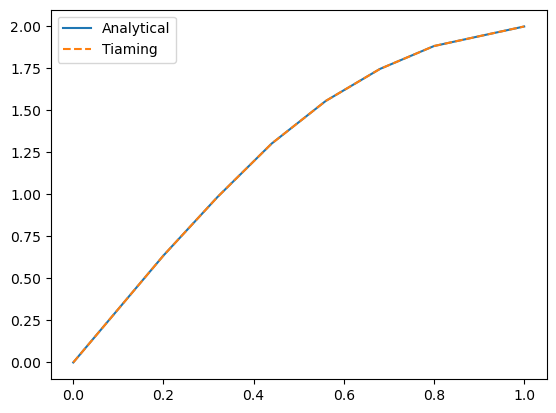

In [4]:
dy = 6

x = np.array([0] + list(np.linspace(0.2,0.8,dy)) + [1])

theta_true = [0.0976270078546495, 0.43037873274483895]
noise_sol_test = np.array([0,6.365626160107796805e-01,9.853532348454457912e-01,
                           1.302974414932300373e+00,1.556834710607004846e+00,1.747096483481726858e+00,1.883543121727832892e+00,2])

y = []
for xx in x:
    y.append(exact_solution (xx, theta_true[0], theta_true[1]))

plt.plot(x,y,label = "Analytical")
plt.plot(x,noise_sol_test,label ="Tiaming",linestyle = "--")

plt.legend()

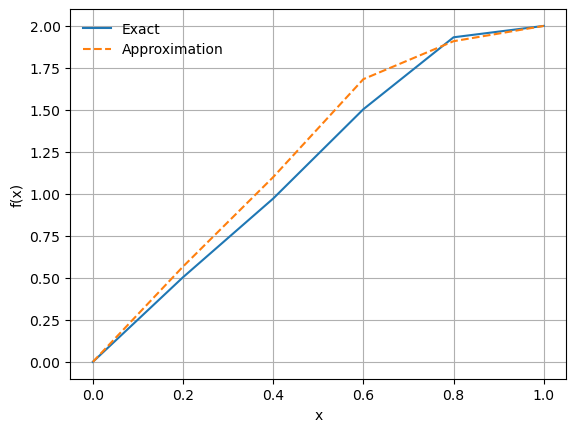

In [10]:
theta_true = [0.01, -0.5]

solver = FEMSolver(theta_true,vert = 5)  # Initialize with first theta value

solution = solver.solve()

x, y = solver.solution_array()

y_e = []
for xx in x[:,0]:
    y_e.append(exact_solution (xx, theta_true[0], theta_true[1]))


plt.plot(x[:,0],y_e,label = "Exact")
plt.plot(x[:,0],y,label ="Approximation",linestyle = "--")
plt.xlabel("x")
plt.ylabel("f(x)")

plt.grid(True)
plt.legend(frameon = False)

## Parametric Deep Galerkin

In [24]:
def k_function(data):
    theta = torch.zeros(data.shape[0],1)
    theta = torch.where((data[:,0].reshape(-1,1) >= 0.25) & (data[:,0].reshape(-1,1) < 0.5), data[:,1].reshape(-1,1),theta)
    theta = torch.where((data[:,0].reshape(-1,1) >= 0.5) & (data[:,0].reshape(-1,1) < 0.75), data[:,2].reshape(-1,1),theta)
    theta = torch.where((data[:,0].reshape(-1,1) >= 0.75) & (data[:,0].reshape(-1,1) < 1), 1, theta)
    return theta
    


def de(self,data_domain,k_function=k_function):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)

    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    
    theta = k_function(data_domain)
    
    ddu_x = torch.autograd.grad(
        torch.exp(theta.reshape(-1,1))*du[:,0].reshape(-1,1),data_domain, 
        grad_outputs=torch.ones_like(du[:,0].reshape(-1,1)),
        retain_graph=True,
        create_graph=True
        )[0]
    
    return ddu_x[:,0].reshape(-1,1) + 4*data_domain[:,0].reshape(-1,1)

def bc_l(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)

def bc_r(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)- 2

DNN.de = de
DNN.bc_l = bc_l
DNN.bc_r = bc_r

In [25]:
def samples_param(size, nparam = 2, min = -1,max = 1):
    return np.random.uniform(min,max,size = (size,nparam))

def samples_param_(size):
    theta_true = np.array([0.0976270078546495, 0.43037873274483895]).reshape(1,-1)
    return np.repeat(theta_true,size,axis=0)



def data_distribution(size):
    x,param = lhs(1,size).reshape(-1,1),samples_param_(size= size)
    
    x, param = torch.Tensor(x),torch.Tensor(param)

    data_int = torch.cat([x,param], axis = 1).float()

    left_bc = torch.cat([torch.zeros_like(x).float(),param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(),param],axis = 1).float()

    return data_int,left_bc,right_bc

In [26]:
def train_adam(pinn,loss,optimizer,epochs, sample_size = 100,repetitions=1):
      print("Starting Adam Training")
      train_loss=[]
      
      for i in range(epochs):
        data_int,left_bc,right_bc = data_distribution(sample_size)
        data_int,left_bc,right_bc = data_int.to(device),left_bc.to(device),right_bc.to(device)

        pde_domain = Variable(data_int,requires_grad=True)
        left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
        
        for _ in range(repetitions):
                optimizer.zero_grad()

                pde_pred  = pinn.de(pde_domain)
                left_bc_pred,right_bc_pred = pinn.bc_l(left_bc),pinn.bc_r(right_bc)

                zeros = torch.zeros_like(pde_pred)

                loss_pde = loss(pde_pred,zeros)
                loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

                Loss =  loss_pde + loss_lbc + loss_rbc
                
                train_loss.append(Loss.item())

                if i % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_pde: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                                 Loss.item(),loss_pde.item(),loss_lbc.item(), loss_rbc.item()))      
                Loss.backward() 

                optimizer.step() 
                
      return train_loss

In [27]:
def train_LBFGS(pinn,loss,optimizer, sample_size = 100):
    print("Starting Training: LBFGS optimizer")
    train_loss=[]

    data_int,left_bc,right_bc = data_distribution(sample_size)
    data_int,left_bc,right_bc = data_int.to(device),left_bc.to(device),right_bc.to(device)

    pde_domain = Variable(data_int,requires_grad=True)
    left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
    
    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred  = pinn.de(pde_domain)
        left_bc_pred,right_bc_pred = pinn.bc_l(left_bc),pinn.bc_r(right_bc)

        zeros = torch.zeros_like(pde_pred)

        loss_pde = loss(pde_pred,zeros)
        loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

        Loss =  loss_pde + loss_lbc + loss_rbc
        
        train_loss.append(Loss.item())

        print('Loss: %.5e, Loss_pde: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                        Loss.item(),loss_pde.item(),loss_lbc.item(), loss_rbc.item())) 
        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 
    return train_loss

In [28]:
# Number of observations
epochs = 1500
nobs = 200
lr = 0.01

layers = [3] + 2*[40] + [1]
model = DNN(layers,activation="tanh")

In [29]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_history = train_adam(model,loss,optimizer,epochs, nobs)

optimizer = torch.optim.LBFGS(model.parameters(), 
    lr=lr, max_iter=50000, max_eval=None, 
    tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe" 
    )

loss_history_b = train_LBFGS(model,loss,optimizer, nobs)

Starting Adam Training
Iter 0, Loss: 8.21440e+00, Loss_pde: 4.79918e+00,Loss_lbc: 1.82850e-03,Loss_rbc: 3.41339e+00
Iter 10, Loss: 4.31794e-01, Loss_pde: 4.07671e-01,Loss_lbc: 1.99723e-02,Loss_rbc: 4.15024e-03
Iter 20, Loss: 3.19328e-01, Loss_pde: 2.51034e-01,Loss_lbc: 5.48090e-02,Loss_rbc: 1.34844e-02
Iter 30, Loss: 1.64047e-01, Loss_pde: 1.14347e-01,Loss_lbc: 7.48671e-03,Loss_rbc: 4.22131e-02
Iter 40, Loss: 1.34796e-01, Loss_pde: 1.26600e-01,Loss_lbc: 1.65166e-03,Loss_rbc: 6.54453e-03
Iter 50, Loss: 1.20624e-01, Loss_pde: 1.16197e-01,Loss_lbc: 4.39564e-03,Loss_rbc: 3.13477e-05
Iter 60, Loss: 1.15841e-01, Loss_pde: 1.14971e-01,Loss_lbc: 3.63358e-04,Loss_rbc: 5.06262e-04
Iter 70, Loss: 1.14787e-01, Loss_pde: 1.14100e-01,Loss_lbc: 1.81808e-04,Loss_rbc: 5.05308e-04
Iter 80, Loss: 1.13300e-01, Loss_pde: 1.13047e-01,Loss_lbc: 1.95974e-04,Loss_rbc: 5.66341e-05
Iter 90, Loss: 1.11314e-01, Loss_pde: 1.11204e-01,Loss_lbc: 3.02107e-05,Loss_rbc: 7.88694e-05
Iter 100, Loss: 1.10307e-01, Loss_pde:

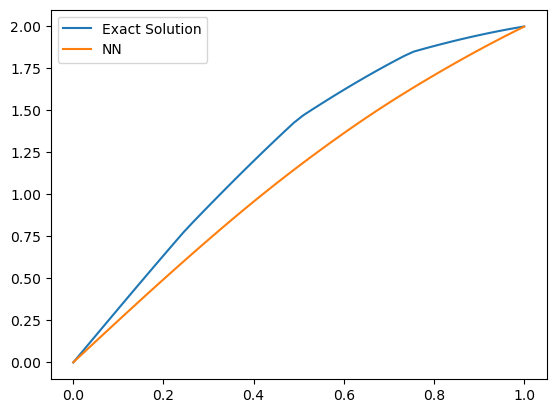

In [30]:
# Number of spatial oberservation points
dy = 50
t = np.linspace(0,1,dy)

theta_true = [0.0976270078546495, 0.43037873274483895]
#theta_true = [-0.6, 1]

data_test =  np.hstack([t.reshape(-1,1),np.ones_like(t).reshape(-1,1)*(theta_true[0]), np.ones_like(t).reshape(-1,1)*(theta_true[1])])

nn = model(torch.tensor(data_test).float()).detach().cpu().numpy().reshape(-1,)

y = []
for xx in t:
    y.append(exact_solution (xx, theta_true[0], theta_true[1]))

plt.plot(t,y,label ="Exact Solution")
plt.plot(t,nn,label = "NN")

plt.legend()

In [31]:
exact_solution (t, theta_true[0], theta_true[1])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [138]:
def test_set(max_space,obs,param,mean,std):

    t = np.linspace(0,max_space,obs)

    sol = (t - t**2) / (2*np.exp(param))

    noise_sol_test = sol + np.random.normal(mean,std, len(t))

    return t, noise_sol_test

In [139]:
import matplotlib.pyplot as plt
from matplotlib import cm


param_trained =  samples_param(-1 , 1,6)
param_trained2 =  samples_param(-1 , 1,6)


# Plotting
fig = plt.figure(figsize=(25,25))
plt.subplots_adjust(hspace=0.25)

for n,(pr1,pr2) in enumerate(zip(param_trained,param_trained2)):

    t, noise_sol_test = test_set(10,30,pr1,0,0.04)

    data_test = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr1), np.ones_like(t).flatten()[:,None]*(pr2)))

    u_pred = model(torch.tensor(data_test).float()).detach().cpu().numpy()

    plt.subplot(8, 2, n + 1)

    plt.scatter(t, u_pred, label = fr"PINN $\alpha$s = {pr1:.1f},{pr2:.1f}", color = "red")

    #plt.scatter(t,-(2/3)*t**3 + 2.5*t, label = "Observations",color= "blue",alpha = 0.5)

    plt.xlabel("t")
    plt.ylabel("u")
    plt.legend(frameon=False)

ValueError: negative dimensions are not allowed

## MCMC Step

In [160]:
def log_prior_alpha(pr1,pr2): #function to evaluate prior pdf of given parameters
    #return norm.logpdf(pr1,loc = 0,scale = 1.5) + norm.logpdf(pr2,loc = 0,scale = 1.5)
    return uniform(loc = -1, scale = 2).logpdf(pr1) + uniform(loc = -1, scale = 2).logpdf(pr2)

def proposals(alpha,dt):
    return np.random.normal(alpha,dt)

In [122]:
def log_likelihood(surrogate,pr1,pr2,t,y_dat,sig = std):
    
    data_ =  np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr1), np.ones_like(t).flatten()[:,None]*(pr2)))

    surg = surrogate(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)
        
    #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    return np.sum(- ((y_dat-surg)**2) / (2*sig**2))

In [123]:
def log_posterior_nn(model,pr1,pr2,t,y):
    return  log_likelihood(model,pr1,pr2,t,y) + log_prior_alpha(pr1,pr2)

In [ ]:
# Number of spatial oberservation points
dy = 6

t = np.array([0] + list(np.linspace(0.2,0.8,dy)) + [1])

noise_sol_test = np.array([0,6.365626160107796805e-01,9.853532348454457912e-01,
                           1.302974414932300373e+00,1.556834710607004846e+00,1.747096483481726858e+00,1.883543121727832892e+00,2])

theta_true = [0.0976270078546495, 0.43037873274483895]

data_ =  np.hstack([t.reshape(-1,1), np.ones_like(t).reshape(-1,1)*(.0976270078546495), np.ones_like(t).reshape(-1,1)*(.43037873274483895)])

nn = model(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)

In [180]:
nn

array([-0.00241643,  0.5039708 ,  0.7951028 ,  1.069453  ,  1.3206937 ,
        1.542248  ,  1.7302663 ,  1.9982805 ], dtype=float32)

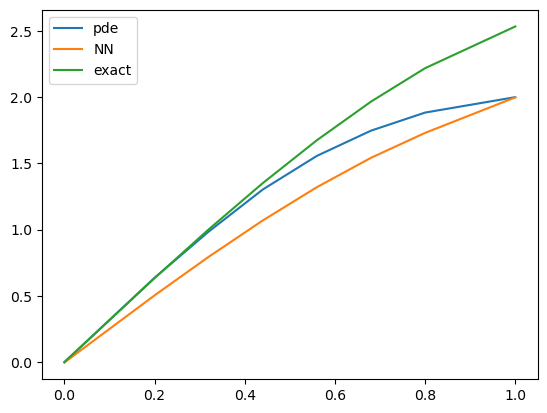

In [181]:
plt.plot(t,noise_sol_test,label ="pde")
plt.plot(t,nn,label = "NN")
plt.plot(t,(-2/3)*t**3 + 3.2*t ,label = "exact")

plt.legend()

In [94]:
alpha_1 = np.linspace(-1,1,50)
alpha_2 = np.linspace(-1,1,50)

alpha_fc_nn = []


for alp1 in alpha_1:
    for alp2 in alpha_2:    
        alpha_fc_nn.append(log_posterior_nn(model,alp1,alp2,t,noise_sol_test))

In [95]:
X, Y = np.meshgrid(alpha_1, alpha_2)
Z = np.array(alpha_fc_nn).reshape(X.shape)
Z2 = np.array(4000*np.exp(alpha_fc_nn)/np.sum(np.exp(alpha_fc_nn))).reshape(X.shape)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


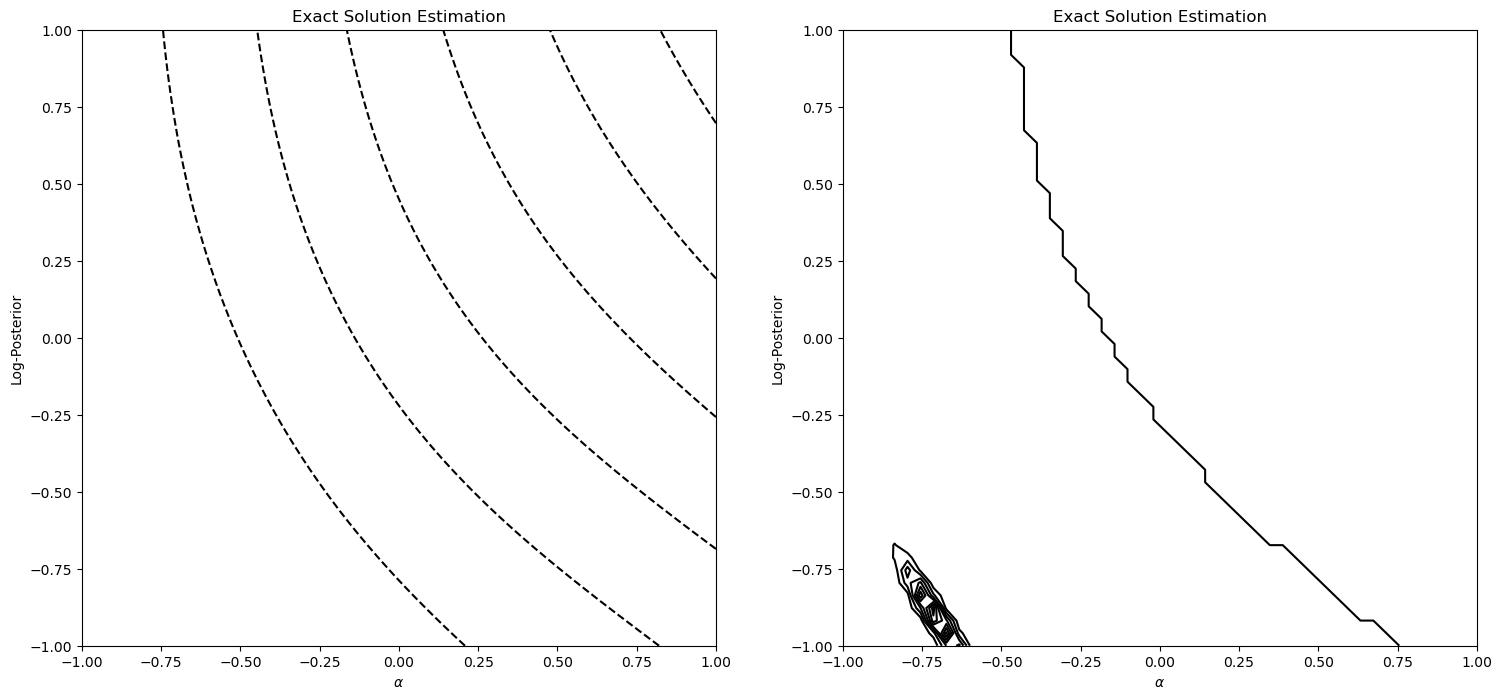

In [96]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=0.25)

plt.subplot(1, 2, 1)
plt.contour(X, Y, Z, colors='black')
#plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("Exact Solution Estimation")
plt.ylabel("Log-Posterior")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)


plt.subplot(1, 2, 2)
plt.contour(X, Y, Z2, colors='black')
#plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("Exact Solution Estimation")
plt.ylabel("Log-Posterior")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)

In [23]:
def Metropolis_Hastings(t,y_dat,nChains, exact = False):

    alpha = 5

    alpha_samp = []
    acceptance_rate, dt = 0, 0.5

    dt_tracker = []
    for i in range(nChains):

        log_posterior =  log_posterior_ex(alpha,t,y_dat) if exact else log_posterior_nn(model,alpha,t,y_dat)
        #log_posterior = log_posterior_ex(alpha,t,y_dat)

        alpha_proposal = proposals(alpha,dt)

        log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat) if exact else log_posterior_nn(model,alpha_proposal,t,y_dat)
        #log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat)

        accept_u = np.random.uniform(0,1)

        ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)

        a = np.min([1.,ratio])

        if accept_u < a:
            alpha = alpha_proposal
            acceptance_rate += 1
        
        dt = dt + dt*(a - 0.234)/ (i+1) 
        dt_tracker.append(dt)
        alpha_samp.append(alpha)


    print(f"Acceptance Rate: {acceptance_rate/nChains:.3f}")

    return alpha_samp,dt_tracker

In [24]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])

In [25]:
alpha_samp,dt_tracker = Metropolis_Hastings(t,noise_sol_test,100000)

/tmp/ipykernel_2216271/1792166774.py:21: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)


Acceptance Rate: 0.012


In [26]:
alpha_samp_true,dt_tracker_true = Metropolis_Hastings(t,noise_sol_test,100000,exact = True)

/tmp/ipykernel_2216271/1792166774.py:21: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)


Acceptance Rate: 0.006


Text(0.5, 0, 'Iteration')

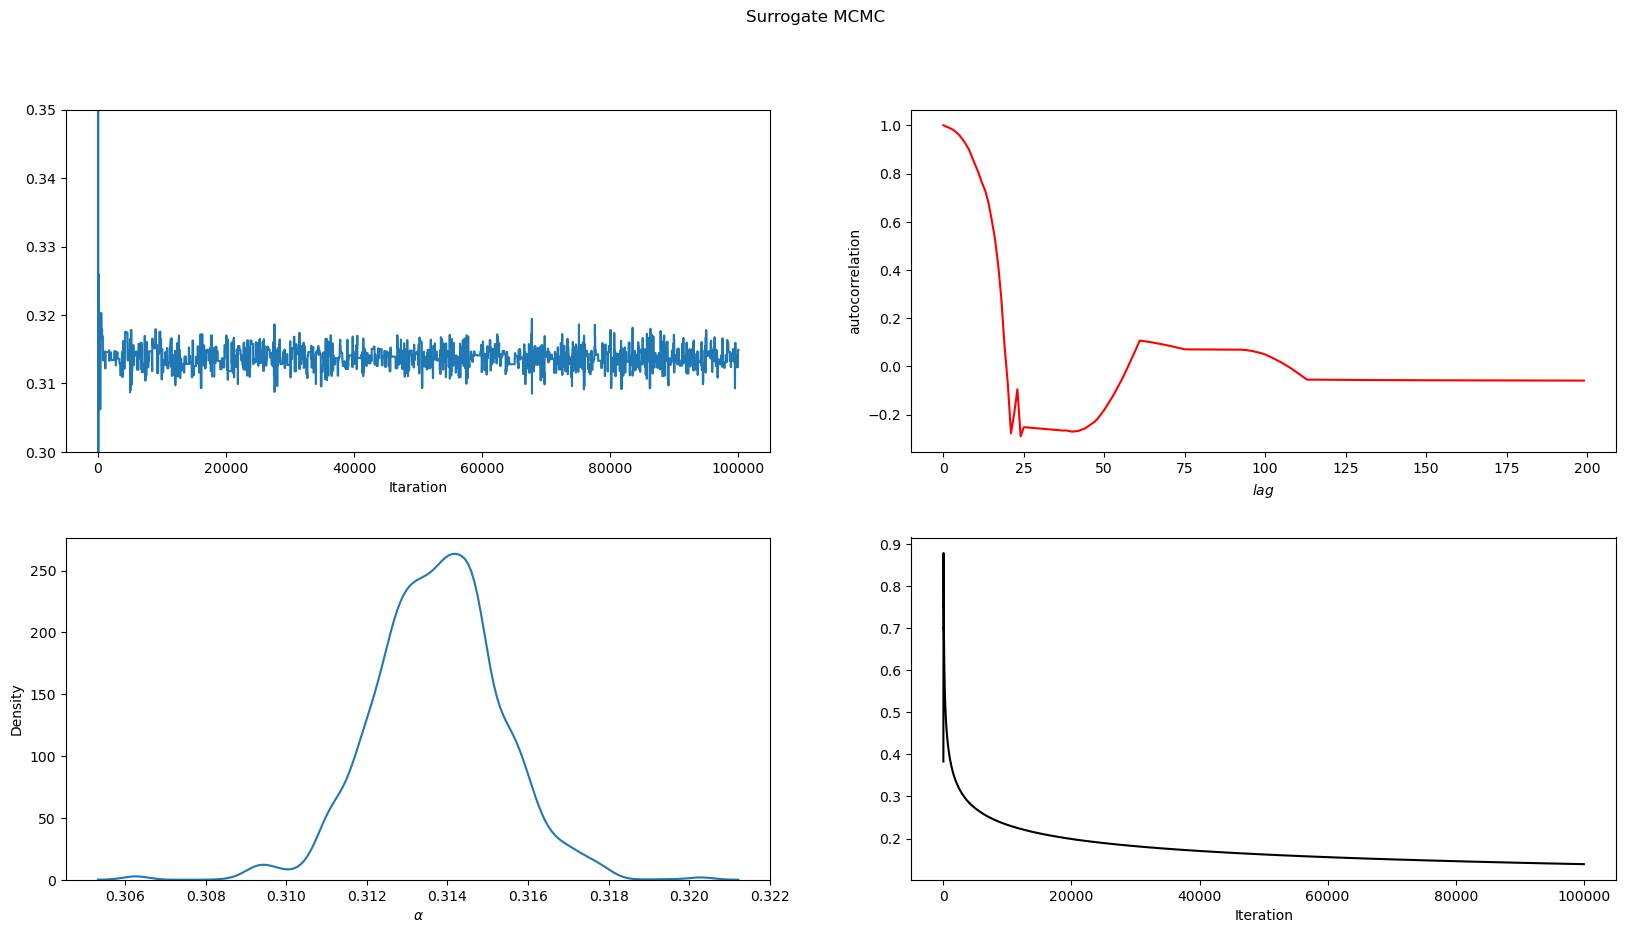

In [37]:
import seaborn as sns

fig = plt.figure(figsize=(20,10))
plt.suptitle("Surrogate MCMC")
plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_samp)
plt.xlabel("Itaration")
plt.ylim(0.3,0.35)

plt.subplot(2, 2, 2)
plt.plot(acf(alpha_samp,200),color = "red")
plt.xlabel(r"$lag$")
plt.ylabel(r"autocorrelation")


plt.subplot(2, 2, 3)
#plt.hist(alpha_samp[200:],color = "orange",alpha = 0.5)
#plt.plot(alpha_,200*np.exp(alpha_fc_3)/np.sum(np.exp(alpha_fc_3)), label = "all obs")
sns.kdeplot(alpha_samp[200:],bw_adjust=2)
plt.xlabel(r"$\alpha$")
#plt.xlim(0.3,0.32)

plt.subplot(2, 2, 4)
plt.plot(dt_tracker,color = "black")
plt.xlabel("Iteration")

Text(0.5, 0, 'Iteration')

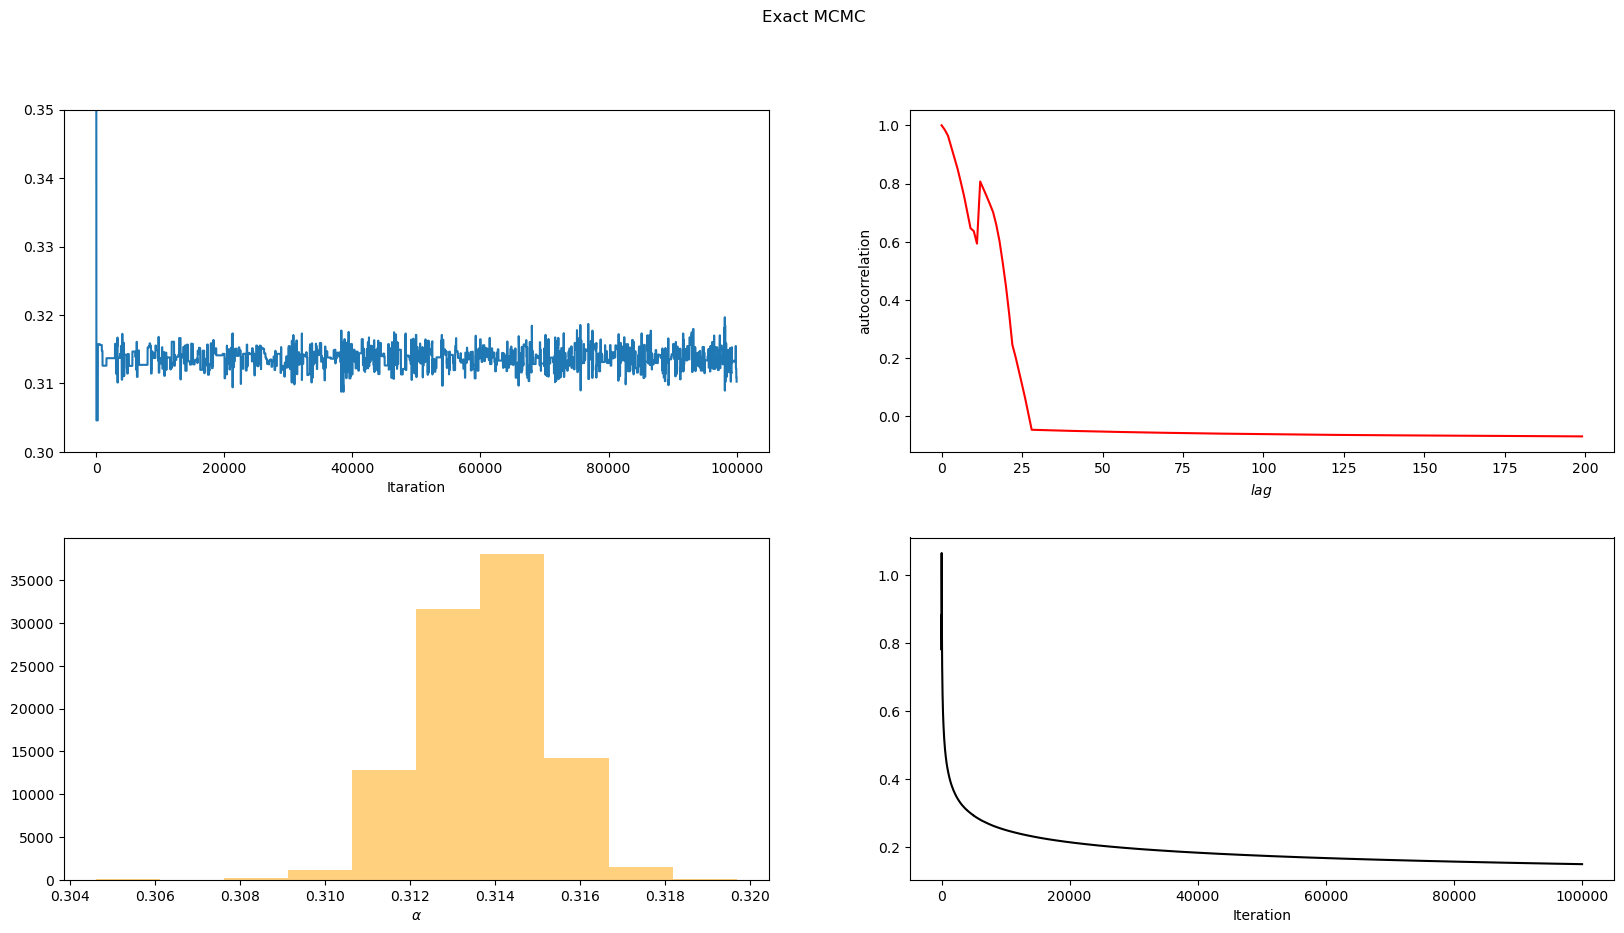

In [197]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Exact MCMC")

plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_samp_true)
plt.xlabel("Itaration")
plt.ylim(0.3,0.35)


plt.subplot(2, 2, 2)
plt.plot(acf(alpha_samp_true,200),color = "red")
plt.xlabel(r"$lag$")
plt.ylabel(r"autocorrelation")


plt.subplot(2, 2, 3)
plt.hist(alpha_samp_true[200:],color = "orange",alpha = 0.5)
plt.xlabel(r"$\alpha$")

plt.subplot(2, 2, 4)
plt.plot(dt_tracker_true,color = "black")
plt.xlabel("Iteration")